In [1]:
import math
import torch
import gpytorch
import pyro
import tqdm
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2
%pdb

Automatic pdb calling has been turned ON


In [2]:
if torch.cuda.is_available():
    torch.set_default_tensor_type(torch.cuda.FloatTensor)

In [16]:
def generate_data(nx=200, split=150, return_all=False):
    full_x = torch.linspace(-15., 15., nx)

    testfn = lambda x: torch.sin(math.pi * x * 1) * torch.exp(-0.05 * (x-5).abs()) 
    full_y = testfn(full_x) + 0.1 * torch.randn_like(full_x)

    if not return_all:
        train_set = ~((full_x > -4.5) * (full_x < 4.5))
        train_x = full_x[train_set]
        train_y = full_y[train_set]

        test_x = full_x[~train_set]
        test_y = full_y[~train_set]

        return train_x, train_y, test_x, test_y
    else:
        return full_x, full_y

train_x, train_y, test_x, test_y = generate_data(500, 300)


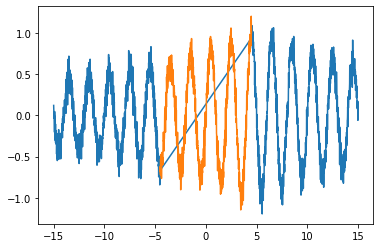

In [17]:
plt.plot(train_x.cpu(), train_y.cpu())
plt.plot(test_x.cpu(), test_y.cpu())

In [18]:
# We will use the simplest form of GP model, exact inference
class SpectralGPModel(gpytorch.models.PyroGP):
    def __init__(self, train_x, train_y, likelihood):
                # Define all the variational stuff
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(
            num_inducing_points=train_y.numel(),
        )
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, train_x, variational_distribution
        )

        # Standard initializtation
        super(SpectralGPModel, self).__init__(
            variational_strategy,
            likelihood,
            num_data=train_y.numel(),
            name_prefix="fkl_regression_model"
        )
        self.likelihood = likelihood
        
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.SpectralGPKernel(train_x, num_locs=50, 
                                                              register_latent_params=True,
                                                             use_latent_model=True)
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [19]:
from gpytorch.priors import LogNormalPrior, NormalPrior, SmoothedBoxPrior
likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint=gpytorch.constraints.Positive())
model = SpectralGPModel(train_x, train_y, likelihood)

model.mean_module.register_prior("mean_prior", SmoothedBoxPrior(-1, 1), "constant")
likelihood.register_prior("noise_prior", SmoothedBoxPrior(1e-3, 1.5), "noise")

In [20]:


model.train();

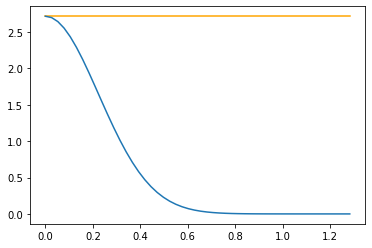

In [21]:
with torch.no_grad():
    omega = model.covar_module.latent_gp_prior.gp_model.train_inputs[0]
    gp_model = model.covar_module.latent_gp_prior.gp_model
    spectral_dist = gp_model(omega)
    
spectral_c_region = [o.cpu().detach() for o in spectral_dist.confidence_region()]
plt.plot(omega.cpu(), model.covar_module.latent_params.cpu().detach().exp(), color='orange')
plt.plot(omega.cpu(), spectral_dist.mean.cpu().exp())

In [22]:
# this is for running the notebook in our testing framework
num_iter =  2500
num_particles = 100

def train():
    optimizer = pyro.optim.Adam({"lr": 1e-2})
    elbo = pyro.infer.Trace_ELBO(num_particles=num_particles, vectorize_particles=True, retain_graph=True)
    svi = pyro.infer.SVI(model.model, model.guide, optimizer, elbo)

    model.train()
    iterator = tqdm.tqdm_notebook(range(num_iter))
    for i in iterator:
        model.zero_grad()
        loss = svi.step(train_x, train_y)
        iterator.set_postfix(loss=loss, noise=model.likelihood.noise.item(), 
                             mean_bias=model.covar_module.latent_gp_prior.gp_model.mean_module.bias.item())

train()

RuntimeError: CUDA out of memory. Tried to allocate 574.00 MiB (GPU 0; 10.92 GiB total capacity; 3.57 GiB already allocated; 154.88 MiB free; 44.31 MiB cached)
              Trace Shapes:       
               Param Sites:       
              Sample Sites:       
fkl_regression_model.u dist | 1750
                      value | 1750

> /home/wesley/Documents/Code/wjm_gpytorch/gpytorch/kernels/spectral_gp_kernel.py(164)compute_kernel_values()
    162         # TODO: use torch.trapz and/or KeOps instead
    163         diff = self.omega[1:] - self.omega[:-1]
--> 164         integral = (diff * (integrand[..., 1:] + integrand[..., :-1]) / 2.0).sum(-1, keepdim=False)
    165 
    166         # divide by integral of density

ipdb> q


In [10]:
model.eval();

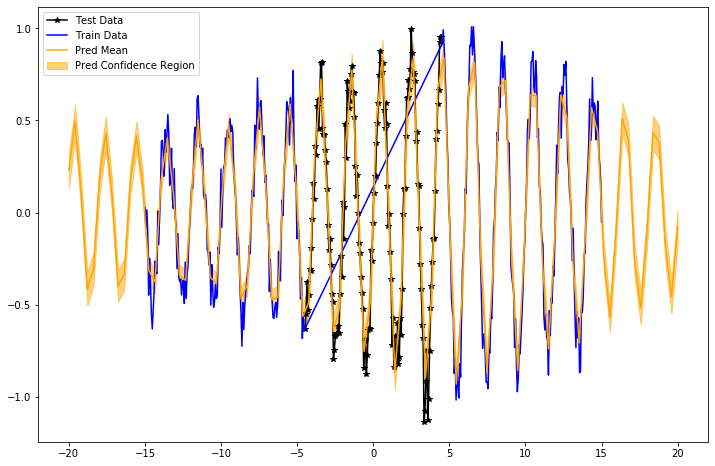

In [14]:
plt.figure(figsize=(12,8))
full_x = torch.linspace(-20, 20)
pred_dist = model(full_x)
conf_region = pred_dist.confidence_region()
pred_mean = pred_dist.mean.data

plt.plot(test_x.cpu(), test_y.cpu(), marker='*', label = 'Test Data', color = 'black')
plt.plot(train_x.cpu(), train_y.cpu(), label = 'Train Data', color = 'blue')
plt.plot(full_x.cpu(), pred_mean.cpu(), label = 'Pred Mean', color = 'orange')
plt.fill_between(full_x.cpu(), conf_region[0].data.cpu(), conf_region[1].data.cpu(), color = 'orange',
                alpha = 0.5, label = 'Pred Confidence Region')
plt.legend()

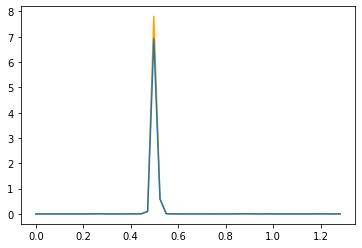

In [15]:
with torch.no_grad():
    omega = model.covar_module.latent_gp_prior.gp_model.train_inputs[0]
    gp_model = model.covar_module.latent_gp_prior.gp_model
    spectral_dist = gp_model(omega)
    
spectral_c_region = [o.cpu().detach() for o in spectral_dist.confidence_region()]
plt.plot(omega.cpu(), model.covar_module.latent_params.cpu().detach().exp(), color='orange')
plt.plot(omega.cpu(), spectral_dist.mean.cpu().exp())